In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import xgboost as xgb
import seaborn as sns

In [2]:
data=pd.read_csv("etai final.csv")
data.head(10)

,Fly Ash,GGBFS,NaOH_Molarity,NaOH amount,Sodium Silicate,Extra Water,Coarse Agg,Fine Agg,Coarse/Fine Agg,SuperPlasticizer,Curing Time(h),Curing Temp(C),Age of Testing (day),Compressive Strength (MPa),Total GHG emission,Total Cost(USD)
0,400.0,0,12,57.0,143.0,40.0,950.0,850.0,1.117647,28.0,24.0,70.0,NaN,53.46,645.335614,222.127
1,400.0,0,12,57.0,143.0,48.0,950.0,850.0,1.117647,28.0,24.0,70.0,NaN,45.01,645.335614,222.127
2,400.0,0,12,57.0,143.0,60.0,950.0,850.0,1.117647,28.0,24.0,70.0,NaN,37.31,645.335614,222.127
3,400.0,0,12,57.0,143.0,80.0,950.0,850.0,1.117647,28.0,24.0,70.0,NaN,22.58,645.335614,222.127
4,400.0,0,12,57.0,143.0,48.0,950.0,850.0,1.117647,28.0,48.0,70.0,NaN,51.03,645.335614,222.127
5,400.0,0,12,57.0,143.0,48.0,950.0,850.0,1.117647,28.0,72.0,70.0,NaN,51.41,645.335614,222.127
6,400.0,0,12,57.0,143.0,48.0,950.0,850.0,1.117647,28.0,96.0,70.0,NaN,51.68,645.335614,222.127
7,400.0,0,12,57.0,143.0,48.0,950.0,850.0,1.117647,28.0,48.0,60.0,NaN,44.81,645.335614,222.127
8,400.0,0,12,57.0,143.0,48.0,950.0,850.0,1.117647,28.0,48.0,80.0,NaN,48.56,645.335614,222.127
9,400.0,0,12,57.0,143.0,48.0,950.0,850.0,1.117647,28.0,48.0,90.0,NaN,47.99,645.335614,222.127


In [3]:
data.isnull().sum() # to see null values

Fly Ash                         0
GGBFS                           0
NaOH_Molarity                   0
NaOH amount                     0
Sodium Silicate                 0
Extra Water                   186
Coarse Agg                      0
Fine Agg                        0
Coarse/Fine Agg                 0
SuperPlasticizer              858
Curing Time(h)                162
Curing Temp(C)                186
Age of Testing (day)          509
Compressive Strength (MPa)      0
Total GHG emission              0
Total Cost(USD)                 0
dtype: int64

In [4]:
y_strength=data['Compressive Strength (MPa)']
y_cost=data['Total Cost(USD)']
y_ghg=data['Total GHG emission']

X = data.drop(columns=['Compressive Strength (MPa)','Total GHG emission','Total Cost(USD)'])

# Random Search

In [5]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
import numpy as np # Import numpy for sqrt


def model_random(X,y):


    # Step: Train/test split (85% temp, 15% test)
    X_temp, X_test, y_temp, y_test = train_test_split(

        X, y, test_size=0.15, random_state=42 )

    X_train, X_val, y_train, y_val = train_test_split(

        X_temp, y_temp, test_size=0.1765, random_state=42)  # 0.1765 of 85% = 15%


    # Define the base XGBoost regressor with a fixed random seed
    xgb_regressor = xgb.XGBRegressor(random_state=42, verbosity=1)

    # Define the hyperparameter search space
    param_grid = {
        'n_estimators': [100, 200, 300, 400, 500],
        'learning_rate': [0.01, 0.03, 0.09, 0.1, 0.2],
        'max_depth': [3, 4, 5, 6],
        'min_child_weight': [1, 3, 5, 7],
        'subsample': [0.6, 0.75, 0.8],
        'colsample_bytree': [0.6, 0.65, 0.7, 0.75],
        'gamma': [0, 0.1, 0.3, 0.5, 1.0],
        'reg_alpha': [0, 0.01, 0.1, 1],
        'reg_lambda': [1, 1.5, 2, 3]
    }

    # Set up the randomized search cross-validator
    tuner = RandomizedSearchCV(
        estimator=xgb_regressor,
        param_distributions=param_grid,
        n_iter=100,
        scoring='neg_root_mean_squared_error',
        cv=3,
        verbose=2,
        random_state=42,
        n_jobs=-1
    )

    # Combine train and validation data for better hyperparameter tuning
    X_combined = pd.concat([X_train, X_val])
    y_combined = pd.concat([y_train, y_val])

    # Perform the randomized search
    tuner.fit(X_combined, y_combined)

    # Show best hyperparameters and corresponding cross-validated RMSE
    print("Optimal hyperparameters:", tuner.best_params_)
    print("Best cross-validated RMSE:", -tuner.best_score_)

    # Use the best model for test prediction
    model = tuner.best_estimator_

    y_test_pred = model.predict(X_test)

    # Evaluate test performance
    rmse_test = np.sqrt(mean_squared_error(y_test, y_test_pred)) # Calculate RMSE by taking the square root
    r2_test = r2_score(y_test, y_test_pred)

    print("Test RMSE:", rmse_test)
    print("Test R²:", r2_test)
    return model

In [6]:
model_strength=model_random(X,y_strength)
model_strength

Fitting 3 folds for each of 100 candidates, totalling 300 fits
Optimal hyperparameters: {'subsample': 0.6, 'reg_lambda': 1, 'reg_alpha': 0.1, 'n_estimators': 300, 'min_child_weight': 1, 'max_depth': 5, 'learning_rate': 0.1, 'gamma': 1.0, 'colsample_bytree': 0.75}
Best cross-validated RMSE: 4.389951185041604
Test RMSE: 3.4938402821126915
Test R²: 0.9521599669083375


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.75, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=1.0, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=5, max_leaves=None,
             min_child_weight=1, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=300, n_jobs=None,
             num_parallel_tree=None, random_state=42, ...)

# Plots

# Heatmap

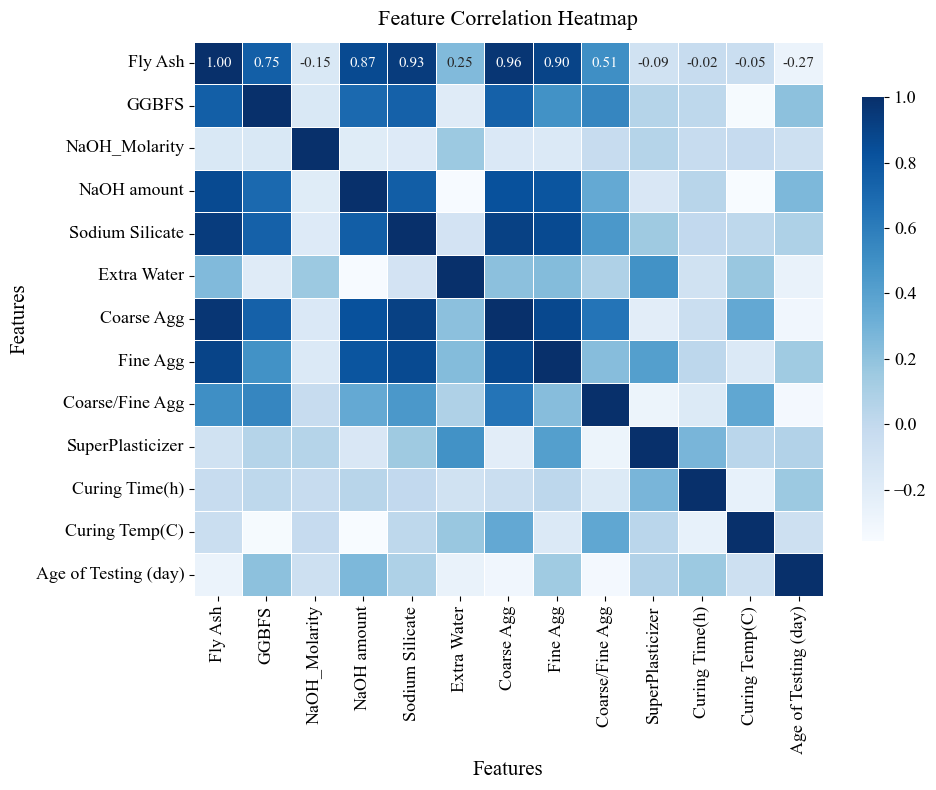

In [7]:
import seaborn as sns
import matplotlib.pyplot as plt

# ---- Elsevier-ish serif fonts ----
plt.rcParams.update({
    "font.family": "serif",
    "font.serif": ["Times New Roman", "Times", "DejaVu Serif"],
    "mathtext.fontset": "stix",
    "axes.titlesize": 16,   # axis title size
    "axes.labelsize": 15,   # axis labels
    "xtick.labelsize": 13,  # tick labels
    "ytick.labelsize": 13,
})

# ---- Correlation matrix ----
corr_matrix = X.corr()

# ---- Heatmap ----
fig, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(
    corr_matrix,
    annot=True,
    cmap="Blues",
    fmt=".2f",
    linewidths=0.5,
    annot_kws={"size": 11},   # annotation font size
    cbar_kws={"shrink": 0.8}  # smaller colorbar
)

# Axis labels
ax.set_xlabel("Features")
ax.set_ylabel("Features")

# No bold / keep simple, formal look
plt.title("Feature Correlation Heatmap", fontsize=16, pad=12)

# Adjust layout
plt.tight_layout()

# Save as PDF (Elsevier-style, high quality)
#fig.savefig("heatmap.pdf", bbox_inches="tight")
plt.show()



# Freature Importance

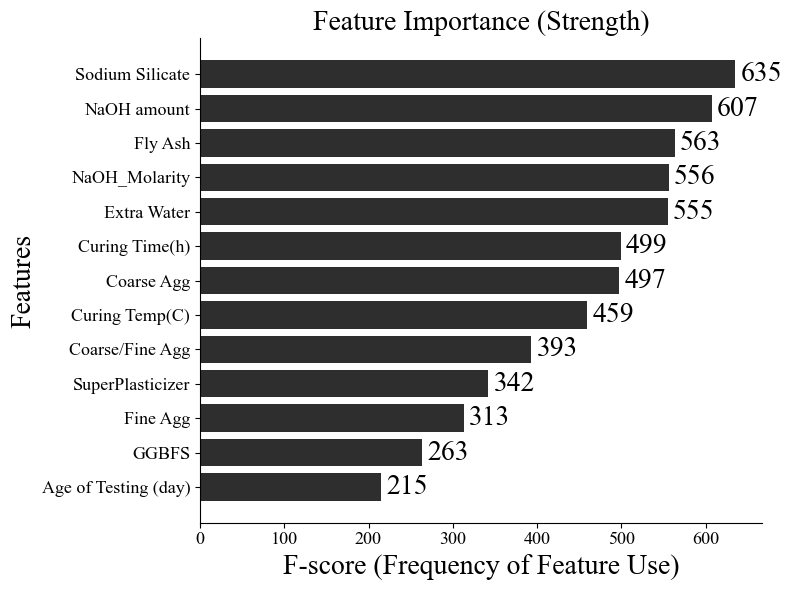

In [8]:
import matplotlib.pyplot as plt
import xgboost as xgb
import numpy as np

def plot_xgb_feature_importance(model, title, ax):
    """
    Plots XGBoost feature importance (F-score) in black color.
    """
    # Get feature importance using XGBoost built-in function
    importance = model.get_booster().get_score(importance_type='weight')

    # Convert to sorted list
    features = list(importance.keys())
    values = list(importance.values())

    # Sort by importance
    sorted_idx = np.argsort(values)
    sorted_features = [features[i] for i in sorted_idx]
    sorted_values = [values[i] for i in sorted_idx]

    # Plot horizontal bars
    ax.barh(sorted_features, sorted_values, color='#2E2E2E')
    ax.set_title(title, fontsize=20)
    ax.set_xlabel("F-score (Frequency of Feature Use)", fontsize=20)
    ax.set_ylabel("Features", fontsize=20)

    # Show values on bars
    for i, v in enumerate(sorted_values):
        ax.text(v + max(sorted_values)*0.01, i, f"{v:.0f}", va='center', fontsize=20)

    # Clean style
    for spine in ['top', 'right']:
        ax.spines[spine].set_visible(False)

# --- Create figure for a single plot ---
fig, ax = plt.subplots(1, 1, figsize=(8, 6)) # Adjusted figure size for a single plot

plot_xgb_feature_importance(model_strength, "Feature Importance (Strength)", ax)

plt.tight_layout()
#plt.savefig("feature_importance1.png", dpi=300, bbox_inches='tight')
plt.show()

# Model Scatter

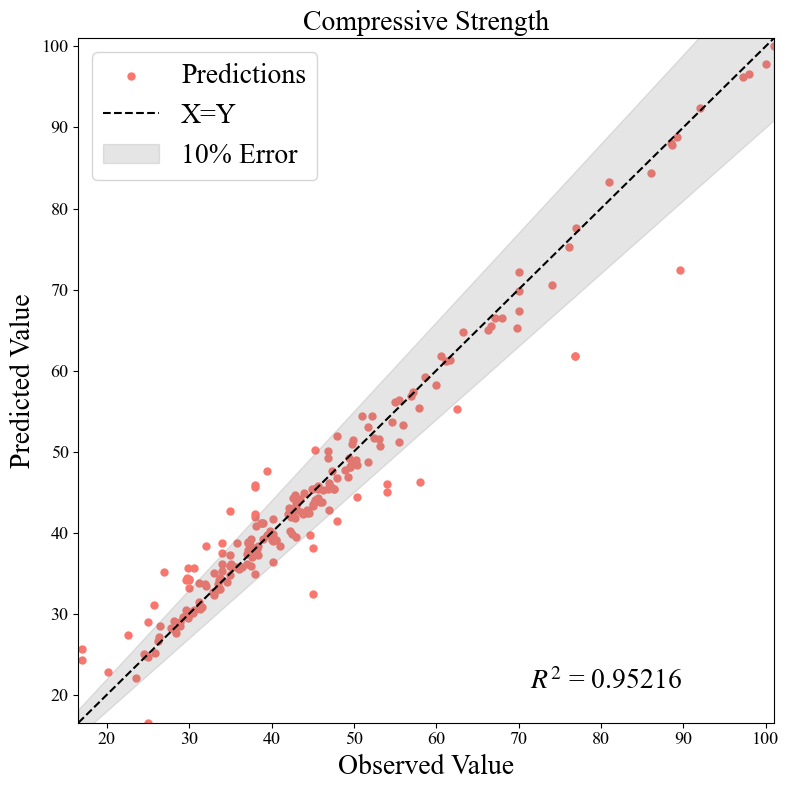

In [9]:
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np

# --- Define a helper function to avoid repeating code ---
def plot_pred_vs_actual(ax, X, y, model, title, color):
    # Split data
    X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=0.15, random_state=42)

    # Predictions
    y_pred = model.predict(X_test)

    # Scatter plot
    ax.scatter(y_test, y_pred, color=color, s=25, label='Predictions')

    # X=Y line
    min_val = min(y_test.min(), y_pred.min())
    max_val = max(y_test.max(), y_pred.max())
    ax.plot([min_val, max_val], [min_val, max_val], 'k--', label='X=Y', linewidth=1.5)

    # ±10% error band
    upper = 1.10 * np.array([min_val, max_val])
    lower = 0.90 * np.array([min_val, max_val])
    ax.fill_between([min_val, max_val], lower, upper, color='grey', alpha=0.2, label='10% Error')

    # R² score
    r2 = r2_score(y_test, y_pred)
    # Dynamic placement: near top-right corner
    x_pos = min_val + (max_val - min_val) * 0.65
    y_pos = min_val + (max_val - min_val) * 0.05
    ax.text(x_pos, y_pos, f"$R^2$ = {r2:.5f}", fontsize=20,
            bbox=dict(facecolor='white', edgecolor='none', alpha=0.6))


    # Labels and style
    ax.set_xlabel("Observed Value", fontsize=20)
    ax.set_ylabel("Predicted Value", fontsize=20)
    ax.set_xlim(min_val, max_val)
    ax.set_ylim(min_val, max_val)
    ax.set_title(title, fontsize=20)
    ax.grid(False)
    ax.legend(loc='upper left', frameon=True, fontsize=20)


# --- Create figure with 1 subplot ---
fig, ax = plt.subplots(1, 1, figsize=(8, 8)) # Adjusted figure size for a single plot

# Color for the single plot
color = '#F8766D'

# Plot the strength model
plot_pred_vs_actual(ax, X, y_strength, model_strength, "Compressive Strength", color)


# Adjust layout
plt.tight_layout()

#plt.savefig("output.png", dpi=300, bbox_inches='tight')
plt.show()

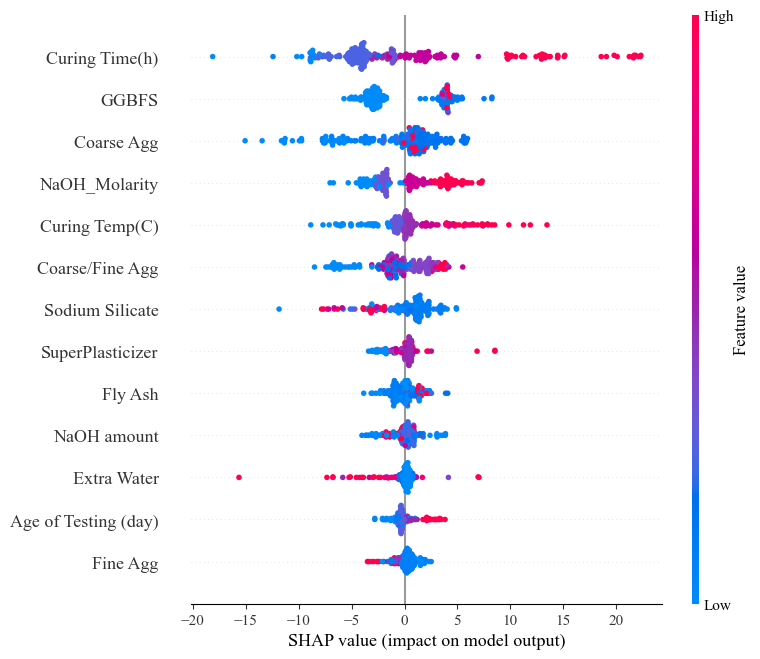

SHAP summary plot saved as shap_summary_plot.pdf


<Figure size 640x480 with 0 Axes>

In [15]:
import shap
from sklearn.model_selection import train_test_split
import numpy as np

# We need to re-split the data to get the same test set as used in the plotting function
X_temp, X_test, y_temp, y_test = train_test_split(X, y_strength, test_size=0.15, random_state=42)

# Handle missing values in X_test by filling with the mean
X_test_filled = X_test.fillna(X_test.mean())

# Create a SHAP explainer using TreeExplainer for XGBoost, passing data directly
explainer = shap.TreeExplainer(model_strength, X_test_filled)

# Calculate SHAP values for the test set
shap_values = explainer.shap_values(X_test_filled)

# Visualize the SHAP values (summary plot)
shap.summary_plot(shap_values, X_test_filled)


# Save the current figure (the SHAP summary plot) as a PDF
plt.savefig("shap_summary_plot.pdf", bbox_inches='tight')

print("SHAP summary plot saved as shap_summary_plot.pdf")

In [16]:
import shap
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

# Split the data
X_temp, X_test, y_temp, y_test = train_test_split(X, y_strength, test_size=0.15, random_state=42)

# Fill missing values
X_test_filled = X_test.fillna(X_test.mean())

# Create SHAP explainer
explainer = shap.TreeExplainer(model_strength, X_test_filled)
shap_values = explainer.shap_values(X_test_filled)

# --- Correct way to save the plot ---
plt.figure()  # Create a new figure context
shap.summary_plot(shap_values, X_test_filled, show=False)  # Do not display it
plt.tight_layout()
plt.savefig("shap_summary_plot.pdf", format="pdf", bbox_inches="tight", dpi=300)
plt.close()

print("✅ SHAP summary plot saved as shap_summary_plot.pdf")


✅ SHAP summary plot saved as shap_summary_plot.pdf


Fly Ash                 float64
GGBFS                     int64
NaOH_Molarity             int64
NaOH amount             float64
Sodium Silicate         float64
Extra Water             float64
Coarse Agg              float64
Fine Agg                float64
Coarse/Fine Agg         float64
SuperPlasticizer        float64
Curing Time(h)          float64
Curing Temp(C)          float64
Age of Testing (day)    float64
dtype: object